## Airline Ticket Dataset — Data Cleaning & Visulization

## Data Cleaning
### 1. Load Data

We load the airline ticket dataset and create a working copy `air` to perform cleaning and feature engineering without modifying the original dataset.



In [55]:
import os, datetime, json, locale, pathlib, urllib, requests, werkzeug, nbformat, google, yaml, warnings
def colab2pdf():
    locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
    NAME = pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f"http://{os.environ['COLAB_JUPYTER_IP']}:{os.environ['KMP_TARGET_PORT']}/api/sessions").json()[0]["name"])))
    TEMP = pathlib.Path("/content/pdfs") / f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{NAME.stem}"; TEMP.mkdir(parents=True, exist_ok=True)
    NB = [cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request("get_ipynb", timeout_sec=30)["ipynb"]), as_version=4).cells if "--Colab2PDF" not in cell.source]
    warnings.filterwarnings('ignore', category=nbformat.validator.MissingIDFieldWarning)
    with (TEMP / f"{NAME.stem}.ipynb").open("w", encoding="utf-8") as nb_copy: nbformat.write(nbformat.v4.new_notebook(cells=NB or [nbformat.v4.new_code_cell("#")]), nb_copy)
    if not pathlib.Path("/usr/local/bin/quarto").exists():
        !wget -q "https://quarto.org/download/latest/quarto-linux-amd64.deb" -P {TEMP} && dpkg -i {TEMP}/quarto-linux-amd64.deb > /dev/null && quarto install tinytex --update-path --quiet
    with (TEMP / "config.yml").open("w", encoding="utf-8") as file: yaml.dump({'include-in-header': [{"text": r"\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}"}],'include-before-body': [{"text": r"\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}"}]}, file)
    !quarto render {TEMP}/{NAME.stem}.ipynb --metadata-file={TEMP}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
    google.colab.files.download(str(TEMP / f"{NAME.stem}.pdf"))

In [56]:
import pandas as pd

import matplotlib.pyplot as plt## Airline Ticket Dataset — Data Cleaning & Preparation

In [57]:
airline = pd.read_excel("airline_ticket_dataset.xlsx")
air = airline.copy()

### 2. Inspect the Raw Dataset

We first examine the first few rows to understand the structure and what each observation looks like.
The dataset contains route-level observations across different **years** and **quarters**, with information on:

* route characteristics (city1, city2, distance)
* demand (passengers)
* ticket prices (fare, fare_lg, fare_low)
* market structure (large_ms, lf_ms)
* city-level aggregated metrics (e.g., TotalFaredPax_city1/city2)

In [58]:
air.head()

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,...,fare_lg,carrier_low,lf_ms,fare_low,TotalFaredPax_city1,TotalPerLFMkts_city1,TotalPerPrem_city1,TotalFaredPax_city2,TotalPerLFMkts_city2,TotalPerPrem_city2
0,2025,2,32467,31703,"Miami, FL (Metropolitan Area)","New York City, NY (Metropolitan Area)",1118,17955,208.52,B6,...,191.48,B6,0.2551,191.48,4.322090e+06,0.88590,-0.065800,2.978413e+06,0.821150,-0.032867
1,2025,2,32575,32457,"Los Angeles, CA (Metropolitan Area)","San Francisco, CA (Metropolitan Area)",372,17310,157.68,WN,...,169.03,AS,0.1193,140.59,2.822942e+06,0.86508,-0.038060,3.284783e+06,0.880833,-0.051467
2,2025,2,32575,31703,"Los Angeles, CA (Metropolitan Area)","New York City, NY (Metropolitan Area)",2510,13648,430.38,DL,...,526.21,B6,0.2272,365.63,2.822942e+06,0.86508,-0.038060,2.978413e+06,0.821150,-0.032867
3,2025,2,31703,31454,"New York City, NY (Metropolitan Area)","Orlando, FL",989,12627,186.50,B6,...,186.10,B6,0.3735,186.10,2.978413e+06,0.82115,-0.032867,8.664260e+06,0.979700,-0.115500
4,2025,2,30977,31703,"Chicago, IL","New York City, NY (Metropolitan Area)",773,11284,221.33,UA,...,238.62,AA,0.2426,217.36,5.402975e+06,0.77515,-0.007850,2.978413e+06,0.821150,-0.032867


### 3. Remove Identifier Columns

The columns `citymarketid_1` and `citymarketid_2` are route identifiers.
They are not meaningful predictors for our analysis and may introduce noise, so we remove them before modeling.

In [59]:
air = air.drop(columns=[
    'citymarketid_1',
    'citymarketid_2'
])
# remove the type 'id'

In [60]:
airline.shape

(14004, 21)

In [61]:
airline.describe()

,Year,quarter,citymarketid_1,citymarketid_2,nsmiles,passengers,fare,large_ms,fare_lg,lf_ms,fare_low,TotalFaredPax_city1,TotalPerLFMkts_city1,TotalPerPrem_city1,TotalFaredPax_city2,TotalPerLFMkts_city2,TotalPerPrem_city2
count,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,14004.000000,1.399700e+04,13997.000000,13997.000000,1.397900e+04,13979.000000,13979.000000
mean,2023.285633,2.357112,31506.638889,32300.714296,1061.839617,1024.581762,237.699035,0.566322,245.713270,0.327737,180.954832,3.220308e+06,0.836383,-0.007360,2.955601e+06,0.832683,-0.038586
std,1.030128,1.108776,1214.185463,1421.194815,589.956663,1475.981346,63.929831,0.174240,77.518173,0.228027,69.241252,2.319576e+06,0.141082,0.108333,2.014224e+06,0.142587,0.119825
min,2022.000000,1.000000,30135.000000,30189.000000,129.000000,163.000000,76.770000,0.209700,76.770000,0.010000,66.160000,2.993000e+04,0.000000,-0.619400,5.464000e+04,0.000000,-0.641100
25%,2022.000000,1.000000,30529.000000,30852.000000,604.000000,316.000000,193.087500,0.431800,193.357500,0.154500,119.590000,1.224800e+06,0.793600,-0.051600,1.582850e+06,0.788400,-0.077500
50%,2023.000000,2.000000,31057.000000,32211.000000,936.000000,526.000000,227.640000,0.541600,239.245000,0.265550,175.215000,2.873210e+06,0.865900,-0.003200,2.764620e+06,0.863200,-0.022700
75%,2024.000000,3.000000,32244.000000,33342.000000,1404.000000,1086.250000,275.615000,0.676725,293.952500,0.444300,225.875000,4.254110e+06,0.922500,0.048400,3.661990e+06,0.939300,0.040500
max,2025.000000,4.000000,35412.000000,35628.000000,2724.000000,21058.000000,676.890000,1.000000,679.120000,1.000000,669.740000,8.840080e+06,1.000000,0.965900,8.840080e+06,1.000000,0.350800


In [62]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  14004 non-null  int64  
 1   quarter               14004 non-null  int64  
 2   citymarketid_1        14004 non-null  int64  
 3   citymarketid_2        14004 non-null  int64  
 4   city1                 14004 non-null  object 
 5   city2                 14004 non-null  object 
 6   nsmiles               14004 non-null  int64  
 7   passengers            14004 non-null  int64  
 8   fare                  14004 non-null  float64
 9   carrier_lg            14004 non-null  object 
 10  large_ms              14004 non-null  float64
 11  fare_lg               14004 non-null  float64
 12  carrier_low           14004 non-null  object 
 13  lf_ms                 14004 non-null  float64
 14  fare_low              14004 non-null  float64
 15  TotalFaredPax_city1




### 4. Missing Value Handling

We check missing values across the dataset.
A small number of rows contain missing values in the city-level aggregate variables (e.g., TotalFaredPax_city1/city2 and related measures).

Since the missingness is minimal relative to the dataset size, we drop rows with missing values to ensure the modeling dataset is complete and consistent.



In [63]:
# null value?
airline.isna().sum()

,0
Year,0
quarter,0
citymarketid_1,0
citymarketid_2,0
city1,0
city2,0
nsmiles,0
passengers,0
fare,0
carrier_lg,0


In [64]:
air = air.dropna()

In [65]:
air.isna().sum()
# null value removed.

,0
Year,0
quarter,0
city1,0
city2,0
nsmiles,0
passengers,0
fare,0
carrier_lg,0
large_ms,0
fare_lg,0



### 5. Data Types Overview

We review variable types to confirm:

* numerical variables are stored as `int` or `float`
* categorical variables (cities, carriers) are stored as `object`

This ensures we apply appropriate transformations for categorical variables before regression modeling.

---

### 6. Create a Time Index (Year + Quarter)

The dataset is quarterly. To represent time as a single numerical variable with **equal spacing** between quarters, we construct:

`time_index = Year * 4 + quarter`

This creates a continuous quarter-by-quarter index (each +1 represents one quarter), which can be used to control for general time trends in airfare and demand.

---



### 6. Create a Time Index (Year + Quarter)

The dataset is quarterly. To represent time as a single numerical variable with **equal spacing** between quarters, we construct:

`time_index = Year * 4 + quarter`

This creates a continuous quarter-by-quarter index (each +1 represents one quarter), which can be used to control for general time trends in airfare and demand.

---

In [66]:
air['time_index'] = air['Year']*4 + air['quarter']
# combine the year and quarter together to show them numerically (as the data differents from years and quarters.)
# use quarter to be the unit
air['time_index']

,time_index
0,8102
1,8102
2,8102
3,8102
4,8102
...,...
13999,8089
14000,8089
14001,8089
14002,8089




### 7. Encode Categorical Variables (Dummy Variables)

The variables `carrier_lg` and `carrier_low` are categorical airline carrier codes.
Regression models require numerical inputs, so we convert these categories into **dummy (indicator) variables** via one-hot encoding.

Each carrier is represented by a binary variable:

* 1 if the observation corresponds to that carrier
* 0 otherwise

We use `drop_first=True` to avoid perfect multicollinearity (the dummy variable trap).
One carrier in each group is treated as a baseline category, and the model interprets other carriers relative to this baseline.

---

### 8. Feature Engineering: Competition Gap

To capture market competition between the dominant carrier and low-cost carrier, we create:

`competition_gap = large_ms - lf_ms`

A larger value indicates the dominant carrier has a substantially larger market share relative to the low-fare carrier, suggesting weaker competition.

---

### 9. Distribution Check (Histograms)

We plot histograms of numerical variables to understand distributions and detect skewness or extreme values.

The distributions of key variables such as `passengers`, `fare`, and `nsmiles` exhibit right-skewness, indicating the presence of large values and long tails.

---

### 10. Log Transformation

To reduce skewness and stabilize variance for regression modeling, we apply log transformations to key strictly-positive variables:

* `log_fare = log(fare)`
* `log_passengers = log(passengers)`
* `log_distance = log(nsmiles)`

The log-transformed variables typically show more compressed ranges and improved distribution shapes, making them more suitable for linear regression.

---

### 11. Summary

After these preprocessing steps, the dataset is:

* free of missing values
* contains encoded carrier variables suitable for regression
* includes engineered features capturing competition structure
* includes log-transformed variables to improve modeling stability

This cleaned dataset is now ready for correlation checks and regression model building.



In [67]:
air = pd.get_dummies(
    air,
    columns=['carrier_lg', 'carrier_low'],
    drop_first=True
)
# Dummy variables are created for airline carriers.
# One category (baseline carrier) is omitted to avoid multicollinearity.

In [68]:
air.columns

Index(['Year', 'quarter', 'city1', 'city2', 'nsmiles', 'passengers', 'fare',
       'large_ms', 'fare_lg', 'lf_ms', 'fare_low', 'TotalFaredPax_city1',
       'TotalPerLFMkts_city1', 'TotalPerPrem_city1', 'TotalFaredPax_city2',
       'TotalPerLFMkts_city2', 'TotalPerPrem_city2', 'time_index',
       'carrier_lg_AS', 'carrier_lg_B6', 'carrier_lg_DL', 'carrier_lg_F9',
       'carrier_lg_G4', 'carrier_lg_MX', 'carrier_lg_NK', 'carrier_lg_SY',
       'carrier_lg_UA', 'carrier_lg_WN', 'carrier_lg_XP', 'carrier_low_AA',
       'carrier_low_AS', 'carrier_low_B6', 'carrier_low_DL', 'carrier_low_F9',
       'carrier_low_G4', 'carrier_low_HA', 'carrier_low_MX', 'carrier_low_NK',
       'carrier_low_SY', 'carrier_low_UA', 'carrier_low_WN', 'carrier_low_XP'],
      dtype='object')

### Encoding Categorical Variables

The variables `carrier_lg` and `carrier_low` are categorical variables representing airline carriers.
Since regression models require numerical inputs, these variables are converted into dummy (indicator) variables using one-hot encoding.

Each airline carrier is transformed into a binary variable that takes value:

- 1 if the observation corresponds to that carrier
- 0 otherwise

We use `drop_first = True` to avoid perfect multicollinearity (the dummy variable trap).
This means one carrier category is treated as the baseline group, and all other carriers are interpreted relative to this baseline.

After this transformation, the original categorical columns are replaced by multiple dummy variables such as:

- `carrier_lg_DL`
- `carrier_lg_WN`
- `carrier_low_AA`
- etc.

These variables allow the model to capture systematic price differences across airlines.

In [69]:
air['competition_gap'] = air['large_ms'] - air['lf_ms']
air['competition_gap']
# use for competition between large ms with small ms.

,competition_gap
0,0.0000
1,0.3813
2,0.0263
3,0.0000
4,0.1902
...,...
13999,0.2240
14000,0.3381
14001,0.0000
14002,0.0000


array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'quarter'}>,
        <Axes: title={'center': 'nsmiles'}>,
        <Axes: title={'center': 'passengers'}>],
       [<Axes: title={'center': 'fare'}>,
        <Axes: title={'center': 'large_ms'}>,
        <Axes: title={'center': 'fare_lg'}>,
        <Axes: title={'center': 'lf_ms'}>],
       [<Axes: title={'center': 'fare_low'}>,
        <Axes: title={'center': 'TotalFaredPax_city1'}>,
        <Axes: title={'center': 'TotalPerLFMkts_city1'}>,
        <Axes: title={'center': 'TotalPerPrem_city1'}>],
       [<Axes: title={'center': 'TotalFaredPax_city2'}>,
        <Axes: title={'center': 'TotalPerLFMkts_city2'}>,
        <Axes: title={'center': 'TotalPerPrem_city2'}>,
        <Axes: title={'center': 'time_index'}>],
       [<Axes: title={'center': 'competition_gap'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

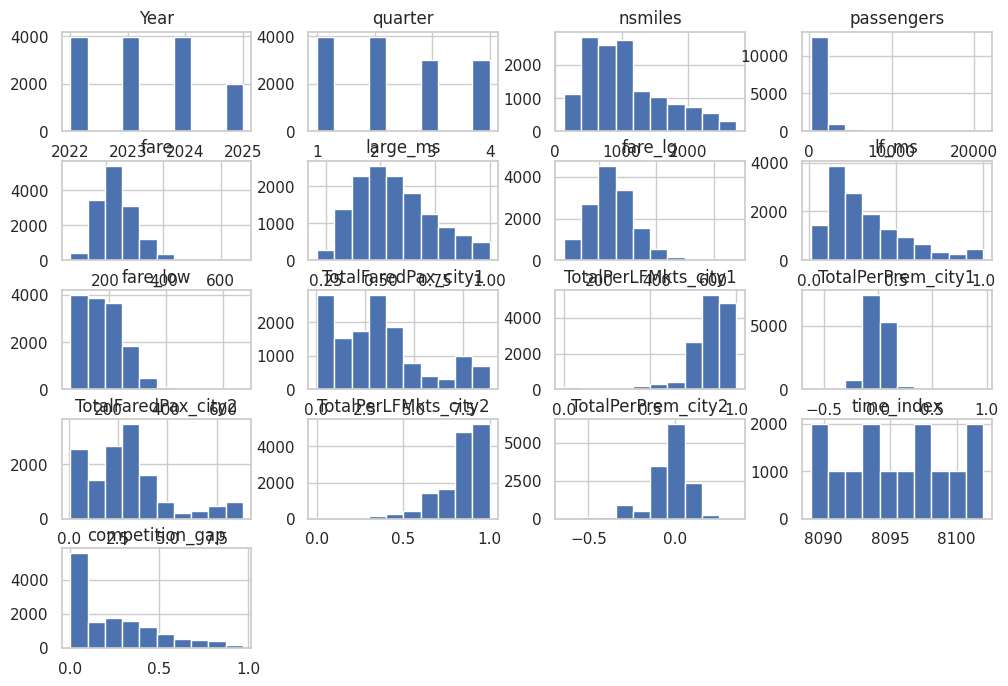

In [70]:
air.hist(figsize=(12,8))

### Distribution of Numerical Variables

Histograms show that several variables, particularly `passengers`, `fare`, and `nsmiles`, are right-skewed.
This indicates the presence of extreme values and suggests that transformations may be helpful before modeling.

In [71]:
import numpy as np

In [72]:
air['log_fare'] = np.log(air['fare'])
air['log_passengers'] = np.log(air['passengers'])
air['log_distance'] = np.log(air['nsmiles'])

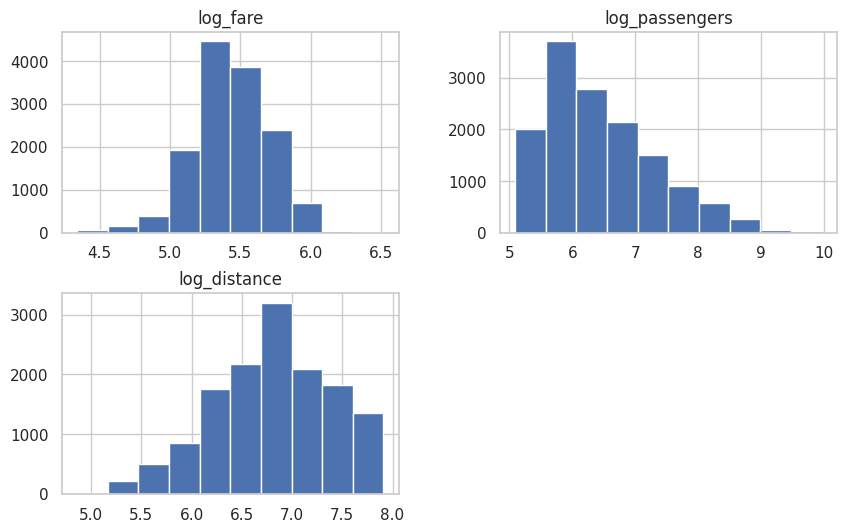

In [73]:
air[['log_fare','log_passengers','log_distance']].hist(figsize=(10,6))
plt.show()

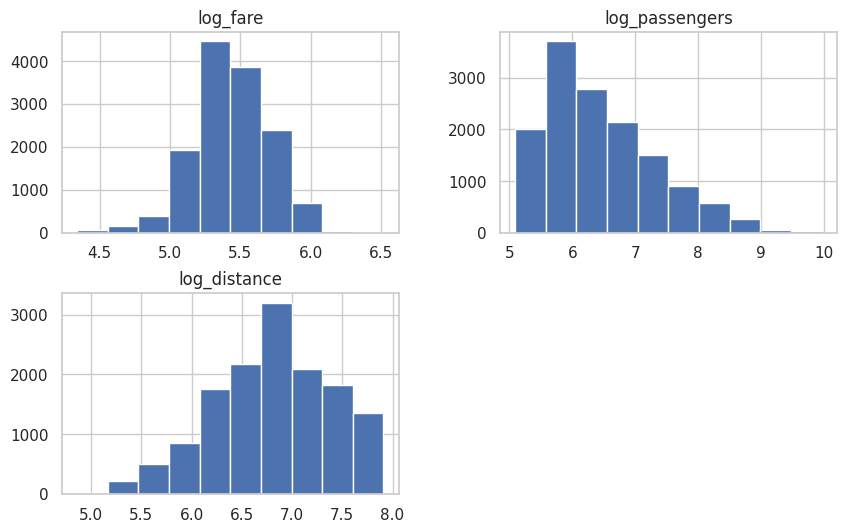

In [74]:
air[['log_fare','log_passengers','log_distance']].hist(figsize=(10,6))
plt.show()

## Visulization

### Hub Dominated
We are examining the relationship between hub dominance and airfare pricing in U.S. airline markets.
Specifically, we ask:
Does greater market concentration at a route (or city hub) lead to systematically higher fares?

Hub dominance refers to the degree to which a single airline controls a large share of the market on a given route or within a city.

In our dataset, we proxy hub dominance using:

`large_ms`: Market share of the largest carrier on a route

/tmp/ipython-input-224/2829789372.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


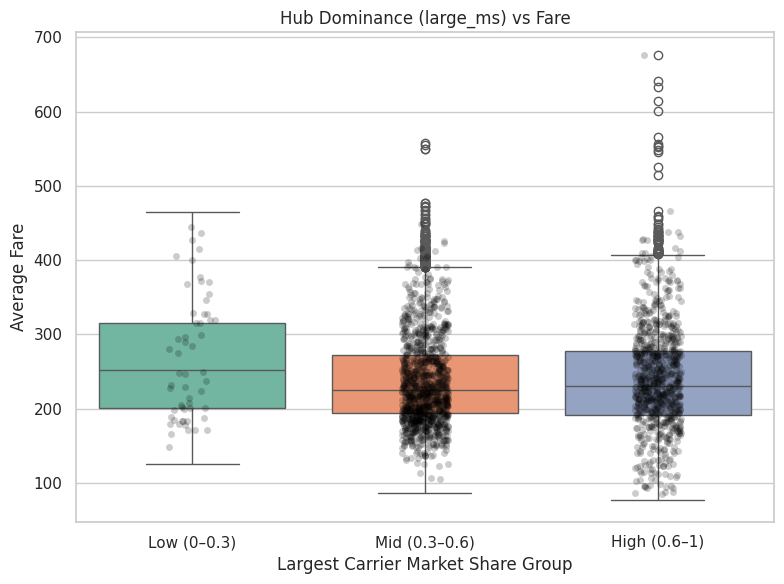

In [75]:
#@title box plot showing Hub Dominated

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

air['ms_group'] = pd.cut(
    air['large_ms'],
    bins=[0, 0.3, 0.6, 1.0],
    labels=['Low (0–0.3)', 'Mid (0.3–0.6)', 'High (0.6–1)'],
    include_lowest=True
)

plt.figure(figsize=(8,6))

sns.boxplot(
    data=air,
    x='ms_group',
    y='fare',
    palette='Set2'
)

sns.stripplot(
    data=air.sample(2000),
    x='ms_group',
    y='fare',
    color='black',
    alpha=0.2,
    jitter=True
)

plt.title("Hub Dominance (large_ms) vs Fare")
plt.xlabel("Largest Carrier Market Share Group")
plt.ylabel("Average Fare")
plt.tight_layout()
plt.show()

/tmp/ipython-input-224/3404623550.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


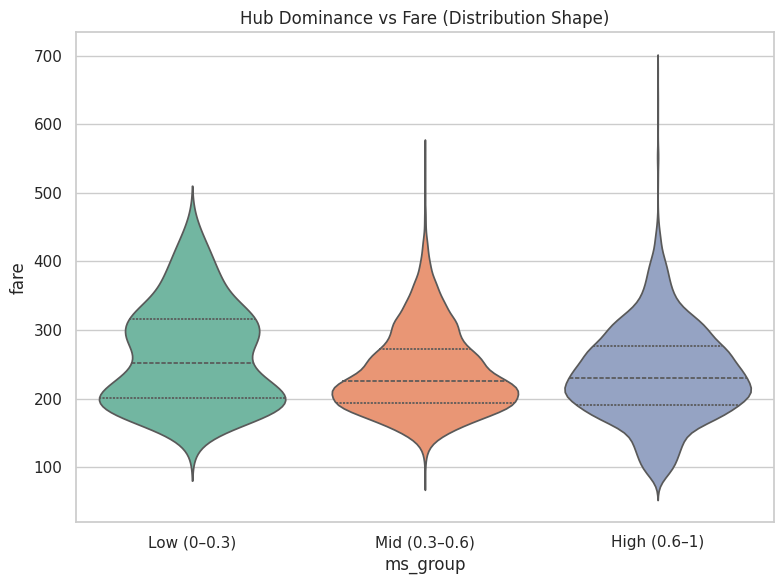

In [76]:
#@title Violin graph
plt.figure(figsize=(8,6))

sns.violinplot(
    data=air,
    x='ms_group',
    y='fare',
    palette='Set2',
    inner='quartile'
)

plt.title("Hub Dominance vs Fare (Distribution Shape)")
plt.tight_layout()
plt.show()

/tmp/ipython-input-224/2312118903.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


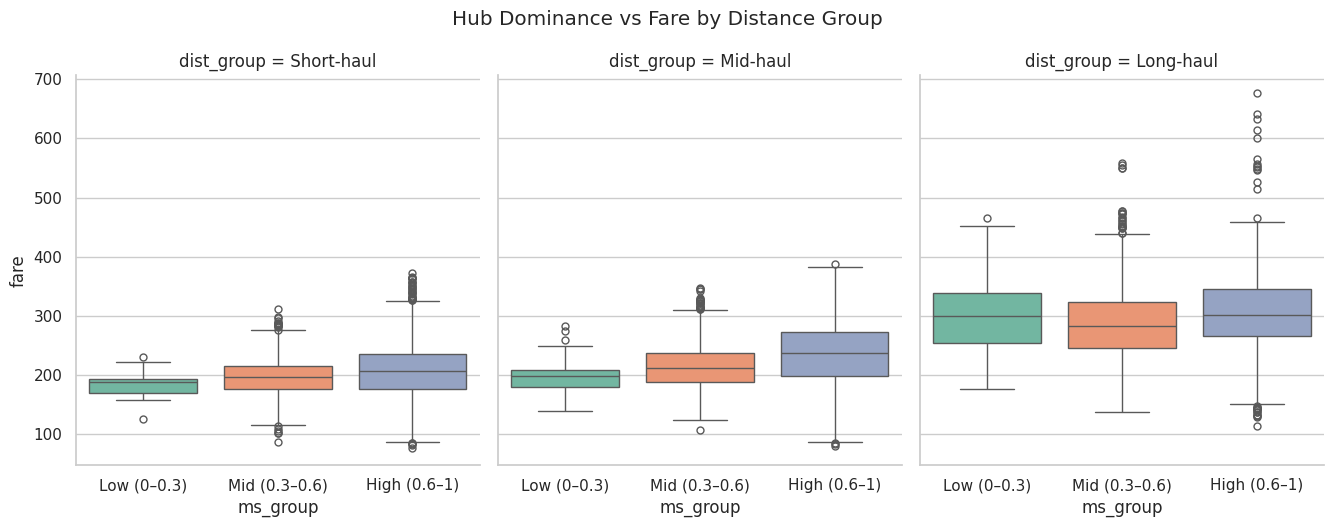

In [77]:
#@title box plot with grouped distance
air['dist_group'] = pd.qcut(
    air['nsmiles'],
    3,
    labels=['Short-haul', 'Mid-haul', 'Long-haul']
)

g = sns.catplot(
    data=air,
    x='ms_group',
    y='fare',
    col='dist_group',
    kind='box',
    palette='Set2',
    height=5,
    aspect=0.9
)

g.fig.suptitle("Hub Dominance vs Fare by Distance Group", y=1.05)
plt.show()

As the largest carrier's market share (`large_ms`) increases, the fare distribution shifts upward: routes in the high concentration group show higher median fares and higher upper quartiles, consistent with greater market power.

### HHI and HHI x LCC
We are analyzing how market concentration and low-cost carrier (LCC) presence jointly influence airline pricing.

Specifically, we investigate whether the effect of market concentration on airfare depends on the presence of low-cost competitors.


#### Key variables:
`HHI` (Herfindahl-Hirschman Index) measures market concentration.
Higher HHI indicates a more concentrated market and potentially greater market power.

LCC Market Share (`lf_ms`) measures the presence of low-cost carriers on a route.

`HHI x LCC` is an interaction term capturing how concentration and low-cost competition jointly affect pricing.

`Fare` is the average ticket price on a route.

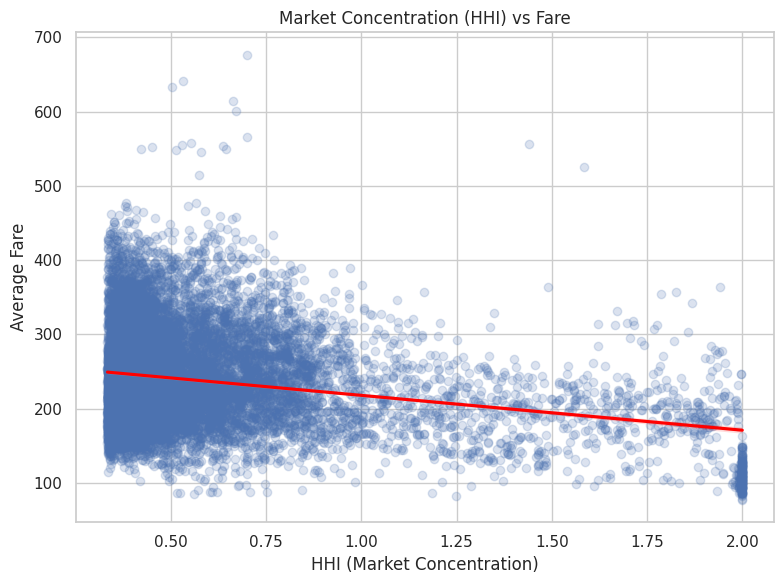

In [78]:
#@title HHI vs Fare
import numpy as np

air['other_ms'] = 1 - air['large_ms'] - air['lf_ms']
air['other_ms'] = air['other_ms'].clip(lower=0)

air['HHI'] = (
    air['large_ms']**2 +
    air['lf_ms']**2 +
    air['other_ms']**2
)

air['HHI_LCC'] = air['HHI'] * air['lf_ms']

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,6))

sns.regplot(
    data=air,
    x='HHI',
    y='fare',
    scatter_kws={'alpha':0.2},
    line_kws={'color':'red'}
)

plt.title("Market Concentration (HHI) vs Fare")
plt.xlabel("HHI (Market Concentration)")
plt.ylabel("Average Fare")
plt.tight_layout()
plt.show()

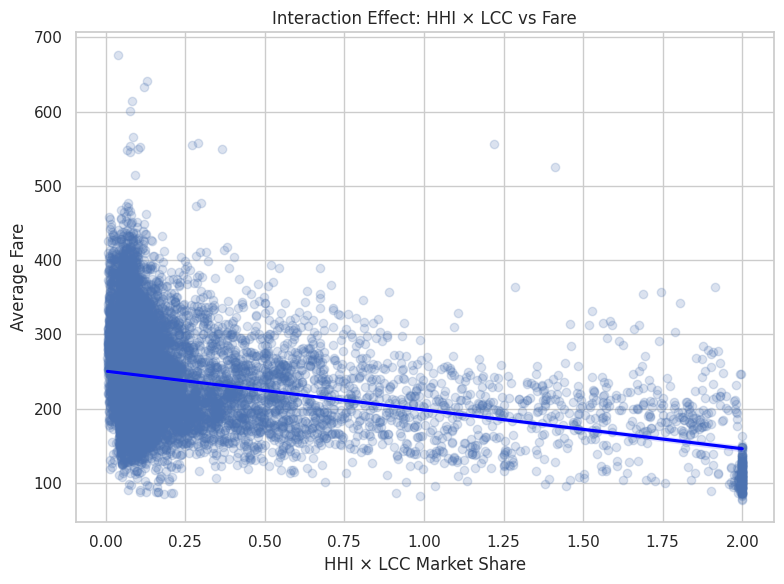

In [79]:
#@title HHI x LCC vs Fare
plt.figure(figsize=(8,6))

sns.regplot(
    data=air,
    x='HHI_LCC',
    y='fare',
    scatter_kws={'alpha':0.2},
    line_kws={'color':'blue'}
)

plt.title("Interaction Effect: HHI × LCC vs Fare")
plt.xlabel("HHI × LCC Market Share")
plt.ylabel("Average Fare")
plt.tight_layout()
plt.show()

Ultimately, we are trying to understand:
Is airfare determined purely by cost and demand factors,
or does market structure — particularly concentration and low-cost competition — play a structural role in pricing?

In [80]:
colab2pdf()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>